In [17]:
# Standard Libraries
import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Image Processing
import cv2
from PIL import Image
from skimage.feature import graycomatrix, graycoprops
from skimage.metrics import structural_similarity as ssim

# File Handling
import h5py

# Deep Learning and PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

# Metrics and Evaluation
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc

# Progress Visualization
from tqdm import tqdm


## Data improvements and enhancements
### Feature Extraction

In [27]:
# Feature extraction functions

def extract_color_histogram(image, bins=(8, 8, 8)):
    """Extracts a color histogram from an RGB image."""
    try:
        # Convert image from BGR to RGB color space
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Calculate the color histogram for the RGB image
        hist = cv2.calcHist([image_rgb], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
        
        # Normalize and flatten the histogram to create a feature vector
        hist = cv2.normalize(hist, hist).flatten()
        return hist
    except Exception as e:
        print(f"Error in extracting color histogram: {e}")
        return None

def extract_hu_moments(image):
    """Extracts Hu Moments from a grayscale image."""
    try:
        # Convert image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Compute image moments
        moments = cv2.moments(gray_image)
        
        # Calculate Hu Moments and flatten the array
        hu_moments = cv2.HuMoments(moments).flatten()
        return hu_moments
    except Exception as e:
        print(f"Error in extracting Hu moments: {e}")
        return None

def extract_haralick_texture(image):
    """Extracts Haralick texture features from a grayscale image."""
    try:
        # Convert image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Compute the gray-level co-occurrence matrix (GLCM)
        glcm = graycomatrix(gray_image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        
        # Extract Haralick texture properties and flatten them into a feature vector
        haralick_features = [graycoprops(glcm, prop).flatten()[0] for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']]
        return np.array(haralick_features)
    except Exception as e:
        print(f"Error in extracting Haralick texture: {e}")
        return None

def extract_image_features_from_hdf5(filename, convert_to_grayscale=True):
    """
    Extracts image features from an HDF5 file and pairs them with their corresponding keys.

    Parameters:
    - filename (str): Path to the HDF5 file containing image data.
    - convert_to_grayscale (bool): Whether to convert images to grayscale (default is True).

    Returns:
    - features_dict (dict): A dictionary where keys are image IDs and values are feature vectors.
    """
    features_dict = {}

    try:
        # Open the HDF5 file
        with h5py.File(filename, "r") as f:
            # List all keys in the HDF5 file (image IDs)
            keys = list(f.keys())
            print("Keys: %s" % keys)

            # Iterate over each key to extract image data and features
            for key in keys:
                try:
                    # Read binary image data from the HDF5 file
                    binary_data = f[key][()]

                    # Convert the binary data to an image using PIL, then to a NumPy array for OpenCV
                    image = Image.open(io.BytesIO(binary_data))
                    image_bgr = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

                    # Check for NaN or infinite values in the image array
                    if np.isnan(image_bgr).any() or np.isinf(image_bgr).any():
                        print(f"Warning: Image from key '{key}' contains NaN or infinite values.")
                        continue

                    # Extract various features from the image
                    color_hist = extract_color_histogram(image_bgr)
                    hu_moments = extract_hu_moments(image_bgr)
                    haralick_texture = extract_haralick_texture(image_bgr)

                    # Ensure all extracted features are valid before combining
                    if color_hist is None or hu_moments is None or haralick_texture is None:
                        print(f"Warning: One or more feature extractions failed for key '{key}'. Skipping.")
                        continue

                    # Combine all features into a single global feature vector
                    global_feature = np.hstack([color_hist, hu_moments, haralick_texture])

                    # Store the feature vector in the dictionary, paired with the key
                    features_dict[key] = global_feature

                except Exception as e:
                    print(f"Error processing key '{key}': {e}")
                    continue

    except IOError as e:
        print(f"Error opening HDF5 file: {e}")
    except Exception as e:
        print(f"Unexpected error: {e}")

    print(f"Extracted features from {len(features_dict)} images.")
    return features_dict


###  Principle Component Analysis

In [28]:
def perform_pca_on_image_dataset(train_filename, val_filename=None, resize_shape=(128, 128), num_images_to_display=5):
    """
    Performs PCA on a training image dataset and optionally applies PCA to a validation dataset, pairing results with keys.
    
    Parameters:
    - train_filename (str): Path to the training HDF5 file.
    - val_filename (str, optional): Path to the validation HDF5 file (default is None).
    - resize_shape (tuple): The size to which images will be resized (default is (128, 128)).
    - num_images_to_display (int): Number of images to display for visual comparison (default is 5).
    
    Returns:
    - tuple: Dictionaries containing PCA results and reconstructed images for training and optionally validation.
    """
    def load_image_dataset(filename):
        """Loads and preprocesses images from an HDF5 file and pairs them with keys."""
        image_dataset = {}  # Dictionary to store image data with keys
        try:
            with h5py.File(filename, "r") as f:
                # Get all keys (image IDs) in the HDF5 file
                keys = list(f.keys())
                print("Keys found:", keys)

                for key in keys:
                    # Load binary image data from the HDF5 file
                    binary_data = f[key][()]
                    # Convert binary data to a PIL image and then to grayscale
                    image = Image.open(io.BytesIO(binary_data)).convert('L')
                    # Resize the image to a consistent shape
                    image = image.resize(resize_shape)
                    # Flatten the image and convert to a NumPy array
                    image_array = np.array(image).astype(float).flatten()

                    # Check for NaN or infinite values and skip invalid images
                    if np.isnan(image_array).any() or np.isinf(image_array).any():
                        print(f"Warning: Image from key '{key}' contains NaN or infinite values.")
                        continue

                    # Store the processed image in the dictionary
                    image_dataset[key] = image_array
        except Exception as e:
            print(f"Error loading HDF5 file {filename}: {e}")
            raise

        return image_dataset

    # Load and process the training dataset
    train_dataset = load_image_dataset(train_filename)
    if not train_dataset:
        raise ValueError("No valid images found in the training dataset.")

    print(f"Training dataset contains {len(train_dataset)} images.")

    pca_result_val, reconstructed_val = None, None

    try:
        # Extract image keys and convert the dataset to a NumPy array for PCA
        train_keys = list(train_dataset.keys())
        train_images = np.array(list(train_dataset.values()))

        # Apply PCA to the training dataset, retaining 95% of the variance
        pca = PCA(n_components=0.95)
        pca_result_train = pca.fit_transform(train_images)
        reconstructed_train = pca.inverse_transform(pca_result_train)

        # Pair PCA results and reconstructed images with their corresponding keys
        reconstructed_train_dict = {key: reconstructed for key, reconstructed in zip(train_keys, reconstructed_train)}
        pca_result_train_dict = {key: pca_result for key, pca_result in zip(train_keys, pca_result_train)}

        # Display a few training images and their PCA-reconstructed versions
        for i, (key, original, reconstructed) in enumerate(zip(train_keys, train_images, reconstructed_train)):
            if i >= num_images_to_display:
                break

            # Reshape the original and reconstructed images for display
            original_image = original.reshape(resize_shape)
            reconstructed_image = reconstructed.reshape(resize_shape)

            # Plot original and reconstructed images side by side
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            axes[0].imshow(original_image, cmap='gray')
            axes[0].set_title('Original Image')
            axes[0].axis('off')

            axes[1].imshow(reconstructed_image, cmap='gray')
            axes[1].set_title('PCA Transformed Image')
            axes[1].axis('off')

            plt.suptitle(f"Training Image {key}")
            plt.show()

            # Calculate and display mean squared error (MSE) and structural similarity index (SSIM)
            mse = np.mean((original_image - reconstructed_image) ** 2)
            similarity_index = ssim(original_image, reconstructed_image, data_range=original_image.max() - original_image.min())

            print(f"Mean Squared Error (MSE) for training image {key}: {mse:.4f}")
            print(f"Structural Similarity Index (SSIM) for training image {key}: {similarity_index:.4f}")

        # Process the validation dataset if provided
        if val_filename:
            val_dataset = load_image_dataset(val_filename)
            if not val_dataset:
                print("Warning: No valid images found in the validation dataset.")
            else:
                print(f"Validation dataset contains {len(val_dataset)} images.")

                val_keys = list(val_dataset.keys())
                val_images = np.array(list(val_dataset.values()))

                # Apply the trained PCA to the validation dataset
                pca_result_val = pca.transform(val_images)
                reconstructed_val = pca.inverse_transform(pca_result_val)

                # Pair PCA results and reconstructed images with their corresponding keys
                reconstructed_val_dict = {key: reconstructed for key, reconstructed in zip(val_keys, reconstructed_val)}
                pca_result_val_dict = {key: pca_result for key, pca_result in zip(val_keys, pca_result_val)}

                # Display a few validation images and their PCA-reconstructed versions
                for i, (key, original, reconstructed) in enumerate(zip(val_keys, val_images, reconstructed_val)):
                    if i >= num_images_to_display:
                        break

                    original_image = original.reshape(resize_shape)
                    reconstructed_image = reconstructed.reshape(resize_shape)

                    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
                    axes[0].imshow(original_image, cmap='gray')
                    axes[0].set_title('Original Validation Image')
                    axes[0].axis('off')

                    axes[1].imshow(reconstructed_image, cmap='gray')
                    axes[1].set_title('PCA Transformed Validation Image')
                    axes[1].axis('off')

                    plt.suptitle(f"Validation Image {key}")
                    plt.show()

                    mse = np.mean((original_image - reconstructed_image) ** 2)
                    similarity_index = ssim(original_image, reconstructed_image, data_range=original_image.max() - original_image.min())

                    print(f"Mean Squared Error (MSE) for validation image {key}: {mse:.4f}")
                    print(f"Structural Similarity Index (SSIM) for validation image {key}: {similarity_index:.4f}")

    except Exception as e:
        print(f"Error performing PCA: {e}")
        raise

    return reconstructed_train_dict, pca_result_train_dict, (reconstructed_val_dict, pca_result_val_dict) if val_filename else (None, None)



 ## Combine Extracted Features and PCA Features to the Data Frame

Keys: ['ISIC_0082829', 'ISIC_0084964', 'ISIC_0096034', 'ISIC_0101462', 'ISIC_0104229', 'ISIC_0104724', 'ISIC_0119495', 'ISIC_0128586', 'ISIC_0131205', 'ISIC_0156375', 'ISIC_0157834', 'ISIC_0179391', 'ISIC_0190307', 'ISIC_0194923', 'ISIC_0199362', 'ISIC_0211092', 'ISIC_0229294', 'ISIC_0240234', 'ISIC_0262513', 'ISIC_0265965', 'ISIC_0279372', 'ISIC_0287900', 'ISIC_0292154', 'ISIC_0293670', 'ISIC_0298906', 'ISIC_0318802', 'ISIC_0330452', 'ISIC_0338239', 'ISIC_0338720', 'ISIC_0376434', 'ISIC_0376940', 'ISIC_0385145', 'ISIC_0386460', 'ISIC_0392749', 'ISIC_0415016', 'ISIC_0421669', 'ISIC_0424991', 'ISIC_0428182', 'ISIC_0436351', 'ISIC_0441223', 'ISIC_0445144', 'ISIC_0452332', 'ISIC_0456714', 'ISIC_0461019', 'ISIC_0477559', 'ISIC_0485425', 'ISIC_0487763', 'ISIC_0490804', 'ISIC_0494599', 'ISIC_0517370', 'ISIC_0521019', 'ISIC_0523668', 'ISIC_0528190', 'ISIC_0529446', 'ISIC_0549968', 'ISIC_0554252', 'ISIC_0562628', 'ISIC_0578834', 'ISIC_0586205', 'ISIC_0587312', 'ISIC_0589993', 'ISIC_0590316', '

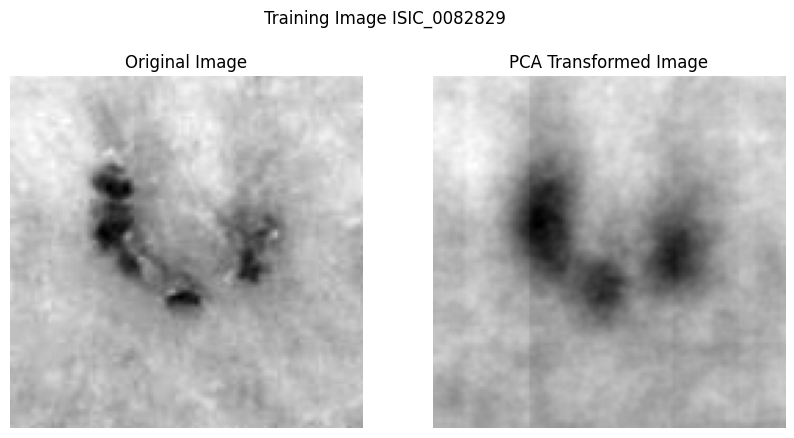

Mean Squared Error (MSE) for training image ISIC_0082829: 52.3732
Structural Similarity Index (SSIM) for training image ISIC_0082829: 0.6071


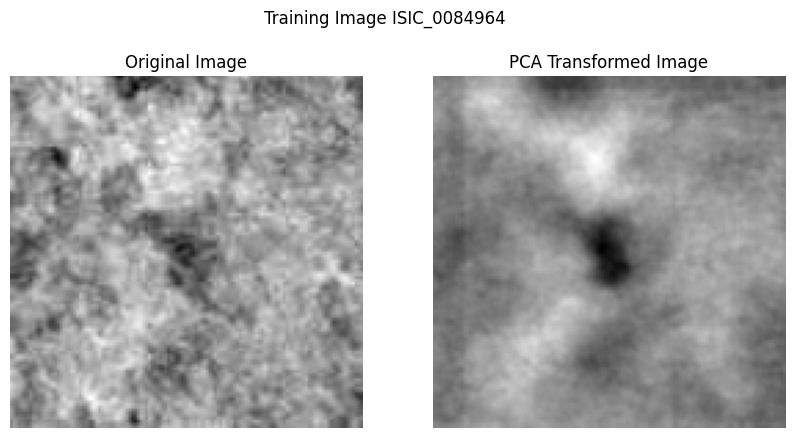

Mean Squared Error (MSE) for training image ISIC_0084964: 59.5097
Structural Similarity Index (SSIM) for training image ISIC_0084964: 0.3040


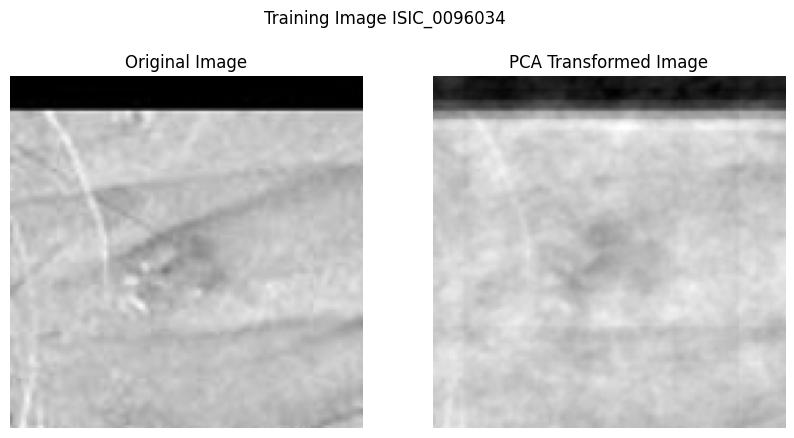

Mean Squared Error (MSE) for training image ISIC_0096034: 114.7713
Structural Similarity Index (SSIM) for training image ISIC_0096034: 0.6328


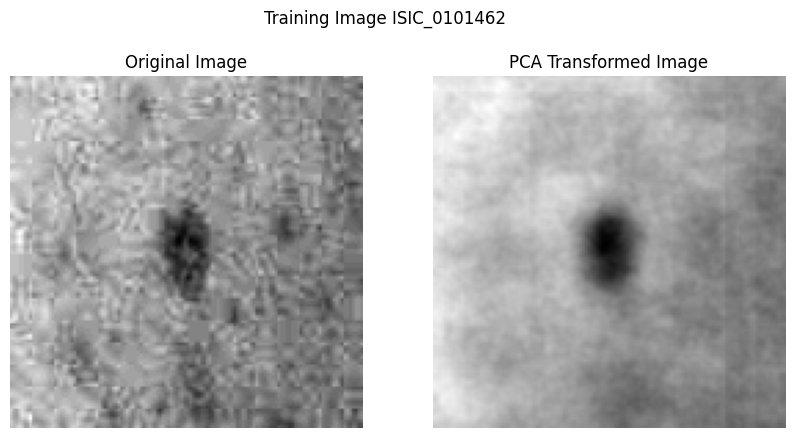

Mean Squared Error (MSE) for training image ISIC_0101462: 5.7142
Structural Similarity Index (SSIM) for training image ISIC_0101462: 0.2798


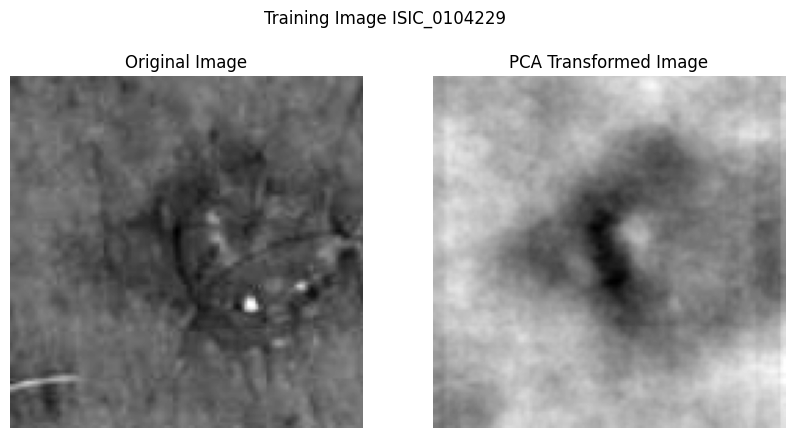

Mean Squared Error (MSE) for training image ISIC_0104229: 72.2659
Structural Similarity Index (SSIM) for training image ISIC_0104229: 0.5131
Keys: ['ISIC_0086819', 'ISIC_0089314', 'ISIC_0098508', 'ISIC_0102886', 'ISIC_0108610', 'ISIC_0108957', 'ISIC_0111800', 'ISIC_0113552', 'ISIC_0114333', 'ISIC_0114480', 'ISIC_0128360', 'ISIC_0128642', 'ISIC_0147417', 'ISIC_0161315', 'ISIC_0163616', 'ISIC_0164324', 'ISIC_0174431', 'ISIC_0175268', 'ISIC_0179683', 'ISIC_0187232', 'ISIC_0197853', 'ISIC_0199204', 'ISIC_0210929', 'ISIC_0216598', 'ISIC_0219025', 'ISIC_0220459', 'ISIC_0222175', 'ISIC_0259487', 'ISIC_0264892', 'ISIC_0283454', 'ISIC_0283728', 'ISIC_0304212', 'ISIC_0321513', 'ISIC_0324109', 'ISIC_0329162', 'ISIC_0330145', 'ISIC_0332345', 'ISIC_0332355', 'ISIC_0337052', 'ISIC_0345137', 'ISIC_0364036', 'ISIC_0365589', 'ISIC_0370739', 'ISIC_0376564', 'ISIC_0392884', 'ISIC_0407740', 'ISIC_0417188', 'ISIC_0423733', 'ISIC_0429138', 'ISIC_0432968', 'ISIC_0436718', 'ISIC_0436985', 'ISIC_0448217', 'ISI

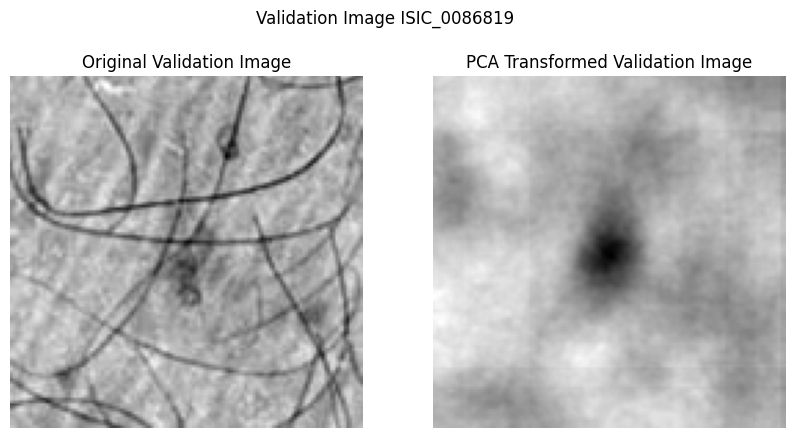

Mean Squared Error (MSE) for validation image ISIC_0086819: 157.4810
Structural Similarity Index (SSIM) for validation image ISIC_0086819: 0.1855


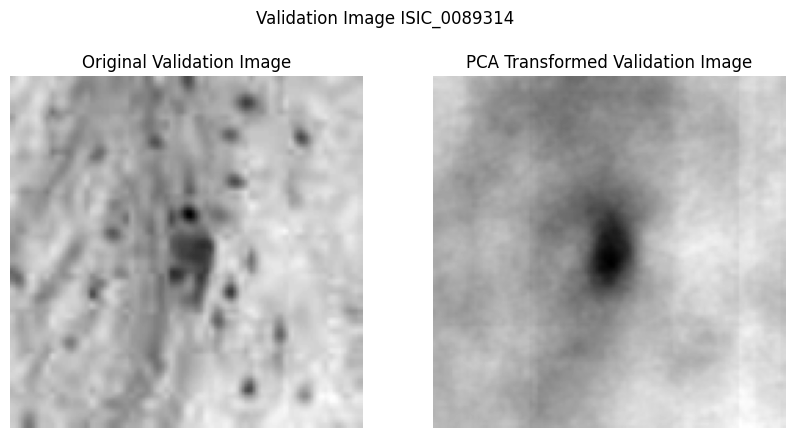

Mean Squared Error (MSE) for validation image ISIC_0089314: 62.5958
Structural Similarity Index (SSIM) for validation image ISIC_0089314: 0.3969


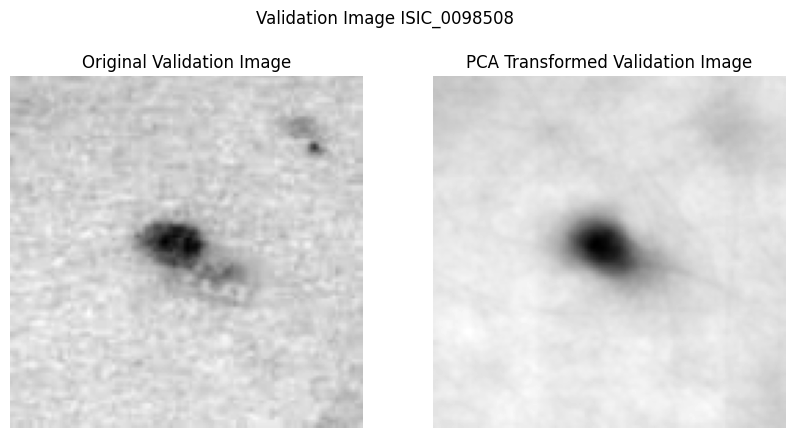

Mean Squared Error (MSE) for validation image ISIC_0098508: 19.3607
Structural Similarity Index (SSIM) for validation image ISIC_0098508: 0.4861


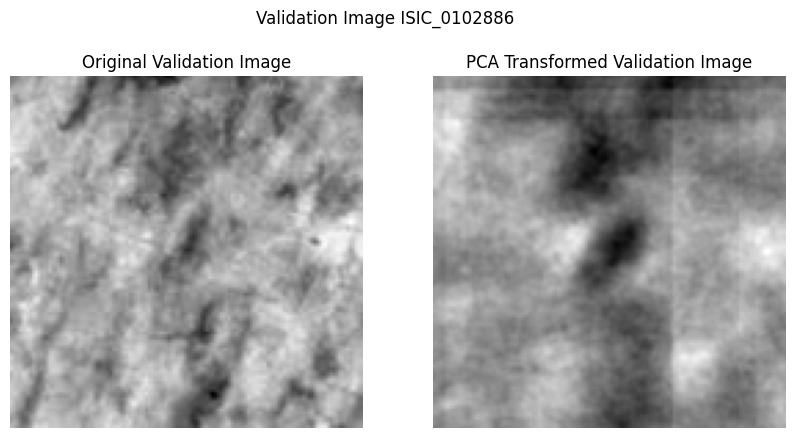

Mean Squared Error (MSE) for validation image ISIC_0102886: 126.4901
Structural Similarity Index (SSIM) for validation image ISIC_0102886: 0.3016


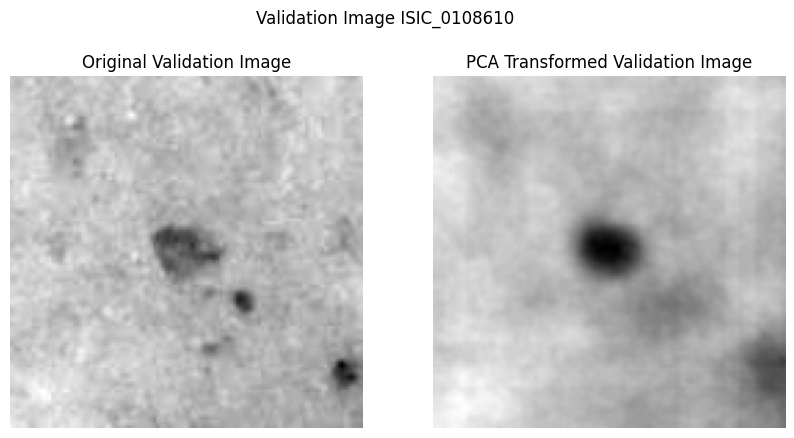

Mean Squared Error (MSE) for validation image ISIC_0108610: 29.1011
Structural Similarity Index (SSIM) for validation image ISIC_0108610: 0.4591
Shape of PCA-reconstructed training image array: (1649, 16384)
Shape of PCA-reconstructed validation image array: (1490, 16384)
Keys: ['ISIC_0082829', 'ISIC_0084964', 'ISIC_0096034', 'ISIC_0101462', 'ISIC_0104229', 'ISIC_0104724', 'ISIC_0119495', 'ISIC_0128586', 'ISIC_0131205', 'ISIC_0156375', 'ISIC_0157834', 'ISIC_0179391', 'ISIC_0190307', 'ISIC_0194923', 'ISIC_0199362', 'ISIC_0211092', 'ISIC_0229294', 'ISIC_0240234', 'ISIC_0262513', 'ISIC_0265965', 'ISIC_0279372', 'ISIC_0287900', 'ISIC_0292154', 'ISIC_0293670', 'ISIC_0298906', 'ISIC_0318802', 'ISIC_0330452', 'ISIC_0338239', 'ISIC_0338720', 'ISIC_0376434', 'ISIC_0376940', 'ISIC_0385145', 'ISIC_0386460', 'ISIC_0392749', 'ISIC_0415016', 'ISIC_0421669', 'ISIC_0424991', 'ISIC_0428182', 'ISIC_0436351', 'ISIC_0441223', 'ISIC_0445144', 'ISIC_0452332', 'ISIC_0456714', 'ISIC_0461019', 'ISIC_0477559', 

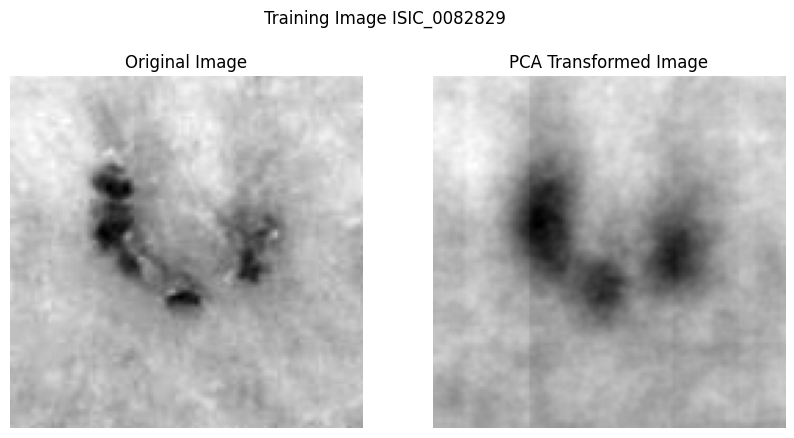

Mean Squared Error (MSE) for training image ISIC_0082829: 52.3732
Structural Similarity Index (SSIM) for training image ISIC_0082829: 0.6071


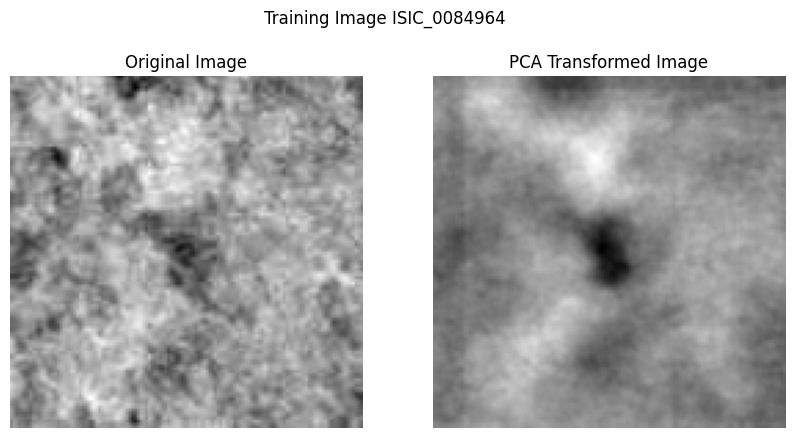

Mean Squared Error (MSE) for training image ISIC_0084964: 59.5097
Structural Similarity Index (SSIM) for training image ISIC_0084964: 0.3040


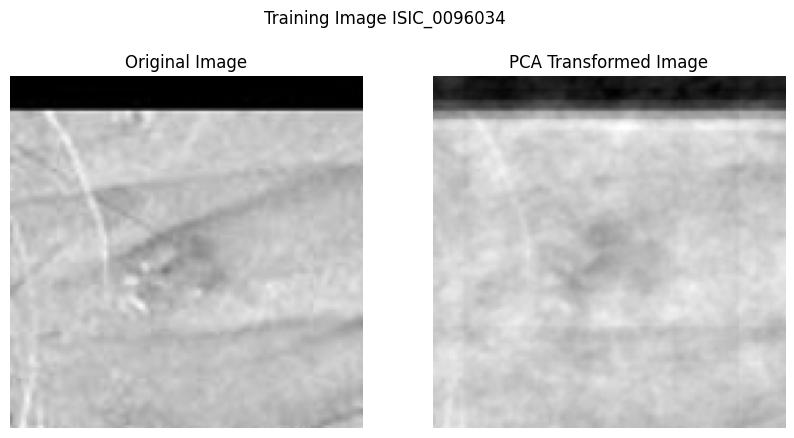

Mean Squared Error (MSE) for training image ISIC_0096034: 114.7713
Structural Similarity Index (SSIM) for training image ISIC_0096034: 0.6328


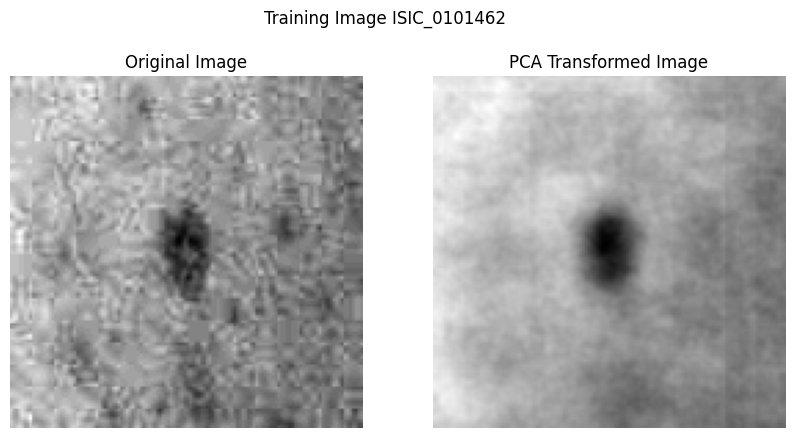

Mean Squared Error (MSE) for training image ISIC_0101462: 5.7142
Structural Similarity Index (SSIM) for training image ISIC_0101462: 0.2798


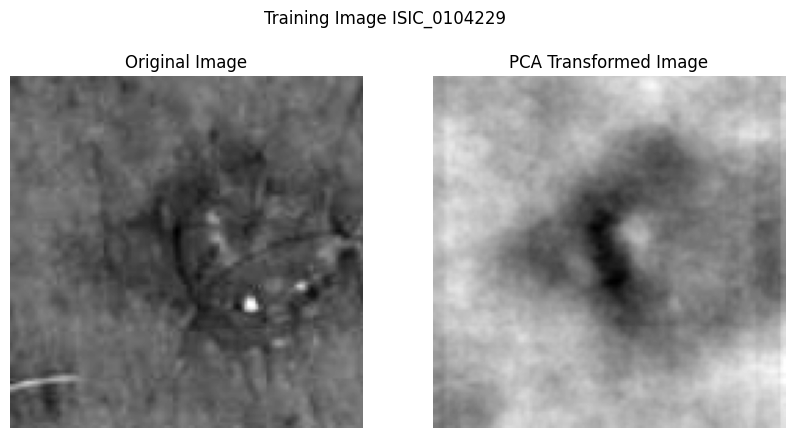

Mean Squared Error (MSE) for training image ISIC_0104229: 72.2659
Structural Similarity Index (SSIM) for training image ISIC_0104229: 0.5131
Keys: ['ISIC_0051822', 'ISIC_0074443', 'ISIC_0076312', 'ISIC_0084823', 'ISIC_0086083', 'ISIC_0088689', 'ISIC_0090295', 'ISIC_0091298', 'ISIC_0130312', 'ISIC_0132671', 'ISIC_0133630', 'ISIC_0135804', 'ISIC_0138066', 'ISIC_0145828', 'ISIC_0150525', 'ISIC_0155288', 'ISIC_0162418', 'ISIC_0163290', 'ISIC_0163860', 'ISIC_0168848', 'ISIC_0171567', 'ISIC_0172028', 'ISIC_0172359', 'ISIC_0181478', 'ISIC_0188012', 'ISIC_0190657', 'ISIC_0196228', 'ISIC_0207113', 'ISIC_0220689', 'ISIC_0223042', 'ISIC_0238218', 'ISIC_0261605', 'ISIC_0265596', 'ISIC_0270636', 'ISIC_0271641', 'ISIC_0274966', 'ISIC_0275647', 'ISIC_0276762', 'ISIC_0292926', 'ISIC_0296582', 'ISIC_0304559', 'ISIC_0315445', 'ISIC_0320737', 'ISIC_0321944', 'ISIC_0345736', 'ISIC_0347017', 'ISIC_0357071', 'ISIC_0364059', 'ISIC_0371751', 'ISIC_0382843', 'ISIC_0394589', 'ISIC_0399772', 'ISIC_0401702', 'ISI

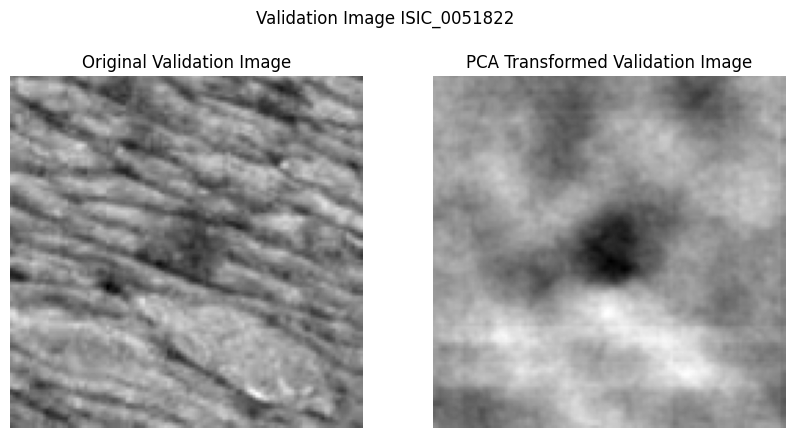

Mean Squared Error (MSE) for validation image ISIC_0051822: 103.0414
Structural Similarity Index (SSIM) for validation image ISIC_0051822: 0.1611


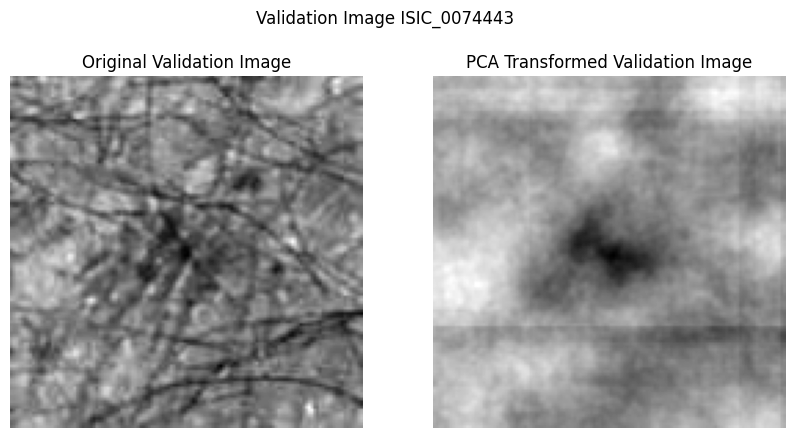

Mean Squared Error (MSE) for validation image ISIC_0074443: 108.7101
Structural Similarity Index (SSIM) for validation image ISIC_0074443: 0.1778


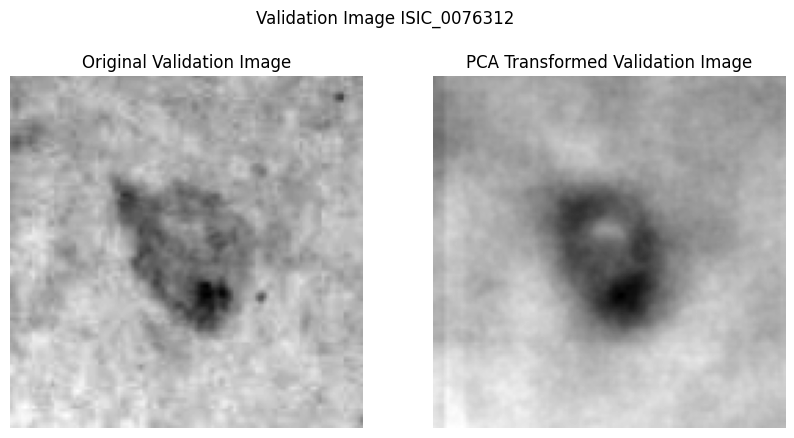

Mean Squared Error (MSE) for validation image ISIC_0076312: 38.2813
Structural Similarity Index (SSIM) for validation image ISIC_0076312: 0.4230


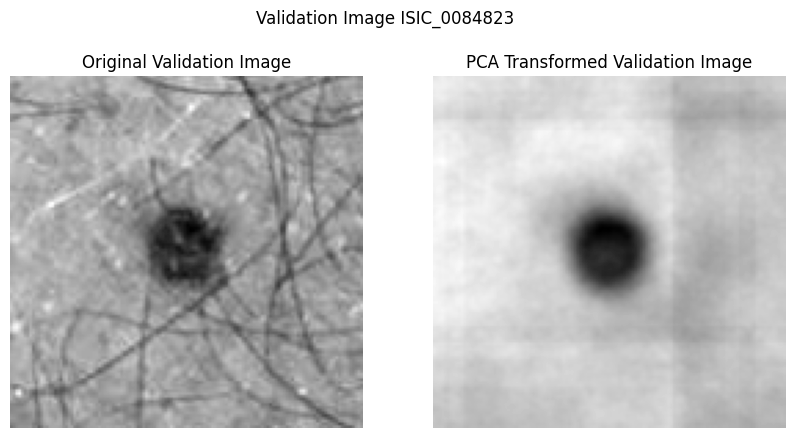

Mean Squared Error (MSE) for validation image ISIC_0084823: 115.6811
Structural Similarity Index (SSIM) for validation image ISIC_0084823: 0.3061


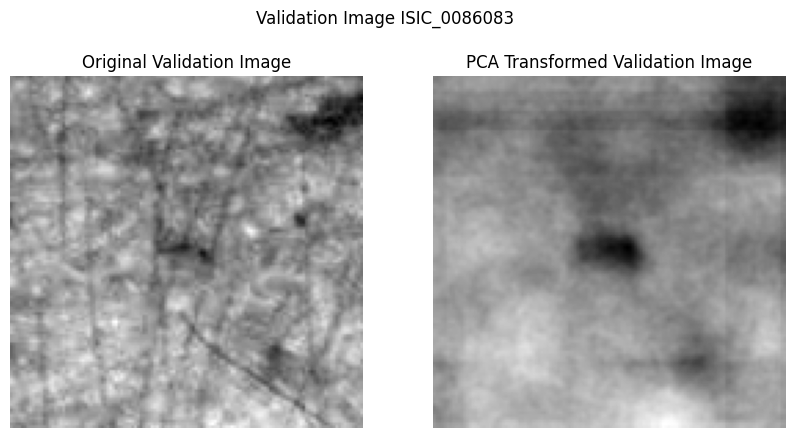

Mean Squared Error (MSE) for validation image ISIC_0086083: 40.0422
Structural Similarity Index (SSIM) for validation image ISIC_0086083: 0.2346
Shape of PCA-reconstructed training image array: (1649, 16384)
Shape of PCA-reconstructed validation image array: (1490, 16384)
Keys: ['ISIC_0082829', 'ISIC_0084964', 'ISIC_0096034', 'ISIC_0101462', 'ISIC_0104229', 'ISIC_0104724', 'ISIC_0119495', 'ISIC_0128586', 'ISIC_0131205', 'ISIC_0156375', 'ISIC_0157834', 'ISIC_0179391', 'ISIC_0190307', 'ISIC_0194923', 'ISIC_0199362', 'ISIC_0211092', 'ISIC_0229294', 'ISIC_0240234', 'ISIC_0262513', 'ISIC_0265965', 'ISIC_0279372', 'ISIC_0287900', 'ISIC_0292154', 'ISIC_0293670', 'ISIC_0298906', 'ISIC_0318802', 'ISIC_0330452', 'ISIC_0338239', 'ISIC_0338720', 'ISIC_0376434', 'ISIC_0376940', 'ISIC_0385145', 'ISIC_0386460', 'ISIC_0392749', 'ISIC_0415016', 'ISIC_0421669', 'ISIC_0424991', 'ISIC_0428182', 'ISIC_0436351', 'ISIC_0441223', 'ISIC_0445144', 'ISIC_0452332', 'ISIC_0456714', 'ISIC_0461019', 'ISIC_0477559', 

In [29]:
# File paths for the training, validation, and test HDF5 image data
train_filename = "../data/raw/train_images.hdf5"
val_filename = "../data/raw/validation_image.hdf5"
test_filename = "../data/raw/test_image.hdf5"

# Perform PCA on the training and validation datasets, obtaining the PCA features
_, pca_features_train, (_, pca_features_val) = perform_pca_on_image_dataset(train_filename, val_filename)

# Perform PCA on the training and test datasets, obtaining the PCA features for testing
_, _, (_, pca_features_test) = perform_pca_on_image_dataset(train_filename, test_filename)

# Extract image features (e.g., color histograms, Hu moments, Haralick textures) from the training dataset
train_image_features = extract_image_features_from_hdf5(train_filename)

# Extract image features from the validation dataset
val_image_features = extract_image_features_from_hdf5(val_filename)

# Extract image features from the test dataset
test_image_features = extract_image_features_from_hdf5(test_filename)

# Load metadata CSV files for training, validation, and test data
train_df = pd.read_csv('../data/processed/processed-train-metadata1.csv')
val_df = pd.read_csv('../data/processed/processed-validation-metadata1.csv')
test_df = pd.read_csv('../data/processed/processed-test-metadata1.csv')

# Ensure that the 'isic_id' column in the dataframes is of type string to match the keys in the extracted features
train_df['isic_id'] = train_df['isic_id'].astype(str)
val_df['isic_id'] = val_df['isic_id'].astype(str)
test_df['isic_id'] = test_df['isic_id'].astype(str)

# Add a new column to the training DataFrame with extracted features by mapping 'isic_id' to the corresponding feature vector
train_df['extracted_features'] = train_df['isic_id'].apply(lambda x: train_image_features.get(x, None))

# Add a new column to the validation DataFrame with extracted features
val_df['extracted_features'] = val_df['isic_id'].apply(lambda x: val_image_features.get(x, None))

# Add a new column to the test DataFrame with extracted features
test_df['extracted_features'] = test_df['isic_id'].apply(lambda x: test_image_features.get(x, None))

# Add a new column to the training DataFrame with PCA features by mapping 'isic_id' to the corresponding PCA feature vector
train_df['pca_features'] = train_df['isic_id'].apply(lambda x: pca_features_train.get(x, None))

# Add a new column to the validation DataFrame with PCA features
val_df['pca_features'] = val_df['isic_id'].apply(lambda x: pca_features_val.get(x, None))

# Add a new column to the test DataFrame with PCA features
test_df['pca_features'] = test_df['isic_id'].apply(lambda x: pca_features_test.get(x, None))





###  Image Data Augmentation



In [30]:


def get_train_transform(resize_size=(256, 256), crop_size=224, rotation_degree=15, normalize_means=(0.485, 0.456, 0.406), normalize_stds=(0.229, 0.224, 0.225)):
    """
    Returns the transformations for the training dataset, including data augmentation for EfficientNet.

    Args:
        resize_size (tuple): The size to resize the image before cropping.
        crop_size (int): The size of the random crop.
        rotation_degree (int): Maximum degree for random rotation.
        normalize_means (tuple): Means for normalization (default matches EfficientNet's training).
        normalize_stds (tuple): Standard deviations for normalization (default matches EfficientNet's training).

    Returns:
        transforms.Compose: The composed transformations for the training set.
    """
    return transforms.Compose([
        transforms.Resize(resize_size),  # Resize to a specified size
        transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),  # Randomly crop the resized image
        transforms.RandomHorizontalFlip(),  # Random horizontal flipping for augmentation
        transforms.RandomRotation(rotation_degree),  # Random rotation
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),  # Optional: Add color jitter for more augmentation
        transforms.ToTensor(),  # Convert image to PyTorch tensor
        transforms.Normalize(normalize_means, normalize_stds)  # Normalize using EfficientNet's means and stds
    ])

def get_normal_transform(resize_size=(256, 256), normalize_means=(0.485, 0.456, 0.406), normalize_stds=(0.229, 0.224, 0.225)):
    """
    Returns the transformations for the validation/test dataset without data augmentation, tailored for EfficientNet.

    Args:
        resize_size (tuple): The size to resize the image.
        normalize_means (tuple): Means for normalization (default matches EfficientNet's training).
        normalize_stds (tuple): Standard deviations for normalization (default matches EfficientNet's training).

    Returns:
        transforms.Compose: The composed transformations for the validation/test set.
    """
    return transforms.Compose([
        transforms.Resize(resize_size),  # Resize to the specified size to maintain consistency
        transforms.CenterCrop(224),  # Center crop to match EfficientNet's input size (224x224)
        transforms.ToTensor(),  # Convert image to PyTorch tensor
        transforms.Normalize(normalize_means, normalize_stds)  # Normalize using EfficientNet's means and stds
    ])


## Dataset and Dataloader

In [31]:
class MultiInputDataset(Dataset):
    def __init__(self, hdf5_file, df, transform=None):
        """
        Multi-input dataset that includes images, extracted features, PCA results, metadata, and labels.

        Parameters:
        - hdf5_file (str): Path to the HDF5 file containing image data.
        - df (pd.DataFrame): DataFrame containing image IDs, labels, and additional features.
        - transform (callable, optional): A function/transform to apply to the images.
        """
        # Open the HDF5 file
        try:
            self.hdf5_file = h5py.File(hdf5_file, 'r')
        except Exception as e:
            raise IOError(f"Could not open HDF5 file: {hdf5_file}. Error: {e}")

        # Store the DataFrame
        self.df = df
        self.image_ids = df['isic_id'].values

        # Check that all image IDs are in the HDF5 file
        for image_id in self.image_ids:
            if str(image_id) not in self.hdf5_file.keys():
                raise ValueError(f"Image id {image_id} not found in HDF5 file.")

        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get the image ID and load the image from HDF5
        image_id = str(self.df.iloc[idx]['isic_id'])
        image_bytes = self.hdf5_file[image_id][()]
        image = Image.open(io.BytesIO(image_bytes)).convert('RGB')

        # Apply any transformations
        if self.transform:
            image_transformed = self.transform(image)
        else:
            image_transformed = np.array(image)

        # Extract the features and PCA result directly from the DataFrame
        extracted_features = self.df.iloc[idx]['extracted_features']
        pca_features = self.df.iloc[idx]['pca_features']

        # Convert features to tensors
        extracted_features_tensor = torch.tensor(extracted_features, dtype=torch.float32)
        pca_features_tensor = torch.tensor(pca_features, dtype=torch.float32)

        # Retrieve the label
        label = torch.tensor(self.df.iloc[idx]['target'], dtype=torch.long)

        # Retrieve other metadata features (if any)
        other_variables = self.df.iloc[idx].drop(['isic_id', 'target', 'extracted_features', 'pca_features']).values.astype(float)
        metadata_tensor = torch.tensor(other_variables, dtype=torch.float32)

        # Return the image, extracted features, PCA features, metadata, and label
        return image_transformed, extracted_features_tensor, pca_features_tensor, metadata_tensor, label



In [32]:
train_dataset = MultiInputDataset('../data/raw/train_images.hdf5',train_df,transform=get_train_transform())
val_dataset = MultiInputDataset('../data/raw/validation_image.hdf5',val_df,transform=get_normal_transform())
test_dataset = MultiInputDataset('../data/raw/test_image.hdf5',test_df,transform=get_normal_transform())

In [33]:


# Create DataLoader objects for training, validation, and testing
effnet_train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
effnet_val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)  # Usually, we don't shuffle validation data
effnet_test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)  # Typically, test data is not shuffled


## Model Architecture

In [34]:


# EfficientNet Model with extended input processing
class CustomImageFeatureEfficientNet(nn.Module):
    def __init__(self, extracted_feature_size, pca_feature_size, metadata_size, pretrained=True):
        """
        Initializes the CustomImageFeatureEfficientNet model with EfficientNet for image features and
        additional layers for extracted, PCA, and metadata inputs.

        Args:
            extracted_feature_size (int): The size of the extracted features input.
            pca_feature_size (int): The size of the PCA-transformed features input.
            metadata_size (int): The size of the metadata input.
            pretrained (bool): Whether to use a pretrained EfficientNet model.
        """
        super(CustomImageFeatureEfficientNet, self).__init__()

        # Load a pretrained EfficientNet model and remove the final classification layer
        try:
            efficientnet = models.efficientnet_b0(pretrained=pretrained)
            self.efficientnet = nn.Sequential(*list(efficientnet.children())[:-1])
            print("EfficientNet loaded successfully.")
        except Exception as e:
            print(f"Error loading EfficientNet model: {e}")
            raise

        # Fully connected layers for image features
        self.fc_image = nn.Sequential(
            nn.Linear(1280, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.8),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512)
        )

        # Fully connected layers for extracted features
        self.fc_extracted_features = nn.Sequential(
            nn.Linear(extracted_feature_size, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.8),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256)
        )

        # Fully connected layers for PCA features
        self.fc_pca_features = nn.Sequential(
            nn.Linear(pca_feature_size, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.8),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128)
        )

        # Fully connected layers for metadata
        self.fc_metadata = nn.Sequential(
            nn.Linear(metadata_size, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.8),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64)
        )

        # Final classification layer for the combined features
        self.fc_combined = nn.Sequential(
            nn.Linear(512 + 256 + 128 + 64, 256),  # Combined feature input size
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.8),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # Binary classification output
        )

    def forward(self, image, extracted_features, pca_features, metadata):
        """
        Forward pass for the model, processing each input type and combining them.

        Args:
            image (torch.Tensor): The input image tensor.
            extracted_features (torch.Tensor): The extracted features tensor.
            pca_features (torch.Tensor): The PCA-transformed features tensor.
            metadata (torch.Tensor): The metadata tensor.

        Returns:
            torch.Tensor: The output prediction of the model.
        """
        try:
            # Pass the image through EfficientNet and process its output
            x = self.efficientnet(image)
            x = x.view(x.size(0), -1)  # Flatten the output
            image_features = self.fc_image(x)

            # Process extracted features
            extracted_features_processed = self.fc_extracted_features(extracted_features)

            # Process PCA features
            pca_features_processed = self.fc_pca_features(pca_features)

            # Process metadata features
            metadata_features_processed = self.fc_metadata(metadata)

            # Concatenate all processed features
            combined_features = torch.cat((image_features, extracted_features_processed, pca_features_processed, metadata_features_processed), dim=1)

            # Final classification
            output = self.fc_combined(combined_features)

            # Apply sigmoid for binary classification (optional, depending on loss function)
            output = torch.sigmoid(output)

            return output

        except Exception as e:
            print(f"Error during forward pass: {e}")
            raise




In [35]:
# Function to compute partial AUC-above-TPR
def score(solution: np.array, submission: np.array, min_tpr: float = 0.80) -> float:
    """
    Compute the partial AUC by focusing on a specific range of true positive rates (TPR).

    Args:
        solution (np.array): Ground truth binary labels.
        submission (np.array): Model predictions.
        min_tpr (float): Minimum true positive rate to calculate partial AUC.

    Returns:
        float: The calculated partial AUC.

    Raises:
        ValueError: If the min_tpr is not within a valid range.
    """
    # Rescale the target to handle sklearn limitations and flip the predictions
    v_gt = abs(solution - 1)
    v_pred = -1.0 * submission
    max_fpr = abs(1 - min_tpr)

    # Compute ROC curve using sklearn
    fpr, tpr, _ = roc_curve(v_gt, v_pred)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError(f"Expected min_tpr in range [0, 1), got: {min_tpr}")

    # Interpolate for partial AUC
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)

    return partial_auc

# Training and validation loop function
def train_and_validate(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    val_dataloader: torch.utils.data.DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    best_model_path: str,
    early_stopping_patience: int = 5,
    min_tpr: float = 0.80

) -> nn.Module:
    """
    Train and validate a PyTorch model with early stopping, AUROC, partial AUC, and error handling.

    Args:
        model (nn.Module): The model to be trained and validated.
        train_dataloader (torch.utils.data.DataLoader): Dataloader for training data.
        val_dataloader (torch.utils.data.DataLoader): Dataloader for validation data.
        criterion (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer to update the model.
        epochs (int): Number of training epochs.
        device (torch.device): The device (CPU or GPU) to use.
        early_stopping_patience (int): Early stopping patience.
        min_tpr (float): The minimum true positive rate for calculating partial AUC.

    Returns:
        nn.Module: The trained model.
    """
    # Initialize tracking variables
    best_val_loss = float('inf')
    best_epoch = 0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    early_stopping_counter = 0

    # Start the training and validation loop
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        # Training phase
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        all_train_labels = []
        all_train_probs = []

        progress_bar = tqdm(train_dataloader, desc=f'Training Epoch {epoch + 1}')

        try:
            # Loop through the training batches
            for i, (image, extracted_features, pca_feature, metadata, labels) in enumerate(progress_bar):
                image, extracted_features, pca_feature, metadata, labels = image.to(device),extracted_features.to(device),pca_feature.to(device), metadata.to(device), labels.float().to(device)
                labels = labels.unsqueeze(1)  # Adjust labels to have the right shape for binary classification

                optimizer.zero_grad()

                # Forward pass
                probs = model(image, extracted_features, pca_feature, metadata)

                if probs.shape != labels.shape:
                    raise ValueError(f"Shape mismatch: Predictions shape {probs.shape} does not match labels shape {labels.shape}")

                # Calculate loss and backpropagate
                loss = criterion(probs, labels)
                loss.backward()
                optimizer.step()

                # Update running loss
                running_train_loss += loss.item()

                # Store labels and predictions for accuracy calculations
                all_train_labels.extend(labels.cpu().detach().numpy())
                all_train_probs.extend(probs.cpu().detach().numpy())

                # Calculate binary predictions for training accuracy
                predicted_train = (probs >= 0.5).float()
                total_train += labels.size(0)
                correct_train += (predicted_train == labels).sum().item()

                # Update progress bar
                progress_bar.set_postfix(train_loss=running_train_loss / (i + 1))

            # Calculate training accuracy and loss
            train_accuracy = 100 * correct_train / total_train
            train_losses.append(running_train_loss / len(train_dataloader))
            train_accuracies.append(train_accuracy)

        except ValueError as ve:
            print(f"Error during training loop: {ve}")
            break

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_probs = []

        progress_bar = tqdm(val_dataloader, desc=f'Validating Epoch {epoch + 1}')

        with torch.no_grad():
            try:
                # Loop through the validation batches
                for i, (image, extracted_features, pca_feature, metadata, labels) in enumerate(progress_bar):
                    image, extracted_features, pca_feature, metadata, labels = image.to(device),extracted_features.to(device),  pca_feature.to(device), metadata.to(device), labels.float().to(device)
                    labels = labels.unsqueeze(1)

                    probs = model(image, extracted_features, pca_feature, metadata)

                    loss = criterion(probs, labels)
                    running_val_loss += loss.item()

                    all_labels.extend(labels.cpu().detach().numpy())
                    all_probs.extend(probs.cpu().detach().numpy())

                    # Calculate binary predictions for validation accuracy
                    predicted = (probs >= 0.5).float()
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                    progress_bar.set_postfix(val_loss=running_val_loss / (i + 1))

                val_accuracy = 100 * correct / total
                val_loss = running_val_loss / len(val_dataloader)
                val_accuracies.append(val_accuracy)
                val_losses.append(val_loss)

                # Calculate AUROC
                try:
                    valid_auroc = roc_auc_score(all_labels, all_probs)
                except ValueError as ve:
                    print(f"AUROC Calculation Error: {ve}")
                    valid_auroc = 0.0

                # Calculate partial AUC-above-TPR
                try:
                    partial_auroc = score(np.array(all_labels), np.array(all_probs), min_tpr=min_tpr)
                except ValueError as ve:
                    print(f"Partial AUC Calculation Error: {ve}")
                    partial_auroc = 0.0

                print(f'Epoch [{epoch}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_loss:.4f}, '
                      f'Train Accuracy : {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%, Val AUROC: {valid_auroc:.4f}, Partial AUROC: {partial_auroc:.4f}')

                # Early stopping based on validation loss
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_epoch = epoch + 1
                    early_stopping_counter = 0
                    torch.save(model.state_dict(), best_model_path)
                else:
                    early_stopping_counter += 1

                if early_stopping_counter >= early_stopping_patience:
                    print(f"Early stopping triggered at epoch {epoch}")
                    break

            except Exception as e:
                print(f"Error during validation loop: {e}")
                break

    print(f"Best Epoch: {best_epoch}, Best Validation Loss: {best_val_loss:.4f}")
    print('Training Complete')

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    # Generate classification report
    try:
        print("Classification Report:")
        print(classification_report(all_labels, (np.array(all_probs) >= 0.5).astype(int), target_names=['Class 0', 'Class 1']))
    except Exception as e:
        print(f"Error generating classification report: {e}")

    return model

## Model training on training data and validation data

I opted to train a new model architecture to accommodate the integration of extracted features and PCA values as inputs for a multi-input model. This change in architecture is necessary to leverage these additional data inputs effectively and enhance the model's predictive capability.

In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CustomImageFeatureEfficientNet(extracted_feature_size=525, pca_feature_size=70, metadata_size=9)  # Assuming 9 features for metadata
model.to(device)
# Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Define the loss function with the class weights
criterion = nn.BCELoss()  # Binary classification loss
# Set the number of epochs
epochs = 20
best_model_path = "best_model.path"

EfficientNet loaded successfully.


/home/jupyter-sohka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jupyter-sohka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20


Validating Epoch 1: 100%|██████████| 94/94 [00:49<00:00,  1.90it/s, val_loss=0.502]


Epoch [0/20], Train Loss: 0.6134, Val Loss: 0.5015, Train Accuracy : 66.70%, Val Accuracy: 85.64%, Val AUROC: 0.7202, Partial AUROC: 0.0439
Epoch 2/20


Validating Epoch 2: 100%|██████████| 94/94 [00:44<00:00,  2.12it/s, val_loss=0.427]


Epoch [1/20], Train Loss: 0.5706, Val Loss: 0.4269, Train Accuracy : 72.11%, Val Accuracy: 88.93%, Val AUROC: 0.7845, Partial AUROC: 0.0645
Epoch 3/20


Validating Epoch 3: 100%|██████████| 94/94 [01:06<00:00,  1.42it/s, val_loss=0.41] 


Epoch [2/20], Train Loss: 0.5250, Val Loss: 0.4097, Train Accuracy : 74.11%, Val Accuracy: 89.60%, Val AUROC: 0.7987, Partial AUROC: 0.0714
Epoch 4/20


Validating Epoch 4: 100%|██████████| 94/94 [00:44<00:00,  2.13it/s, val_loss=0.324]


Epoch [3/20], Train Loss: 0.4841, Val Loss: 0.3245, Train Accuracy : 77.94%, Val Accuracy: 89.53%, Val AUROC: 0.8253, Partial AUROC: 0.0859
Epoch 5/20


Validating Epoch 5: 100%|██████████| 94/94 [00:44<00:00,  2.11it/s, val_loss=0.305]


Epoch [4/20], Train Loss: 0.4892, Val Loss: 0.3052, Train Accuracy : 76.22%, Val Accuracy: 89.19%, Val AUROC: 0.8441, Partial AUROC: 0.1042
Epoch 6/20


Validating Epoch 6: 100%|██████████| 94/94 [00:43<00:00,  2.14it/s, val_loss=0.304]


Epoch [5/20], Train Loss: 0.4469, Val Loss: 0.3045, Train Accuracy : 78.42%, Val Accuracy: 88.19%, Val AUROC: 0.8289, Partial AUROC: 0.0956
Epoch 7/20


Validating Epoch 7: 100%|██████████| 94/94 [00:50<00:00,  1.86it/s, val_loss=0.349]


Epoch [6/20], Train Loss: 0.4203, Val Loss: 0.3491, Train Accuracy : 80.48%, Val Accuracy: 86.98%, Val AUROC: 0.8373, Partial AUROC: 0.0920
Epoch 8/20


Validating Epoch 8: 100%|██████████| 94/94 [00:43<00:00,  2.14it/s, val_loss=0.312]


Epoch [7/20], Train Loss: 0.4297, Val Loss: 0.3118, Train Accuracy : 81.87%, Val Accuracy: 89.87%, Val AUROC: 0.8523, Partial AUROC: 0.1042
Epoch 9/20


Validating Epoch 9: 100%|██████████| 94/94 [00:46<00:00,  2.01it/s, val_loss=0.299]


Epoch [8/20], Train Loss: 0.4247, Val Loss: 0.2988, Train Accuracy : 81.05%, Val Accuracy: 87.58%, Val AUROC: 0.8513, Partial AUROC: 0.1092
Epoch 10/20


Validating Epoch 10: 100%|██████████| 94/94 [00:45<00:00,  2.08it/s, val_loss=0.279]


Epoch [9/20], Train Loss: 0.4310, Val Loss: 0.2791, Train Accuracy : 80.86%, Val Accuracy: 89.66%, Val AUROC: 0.8521, Partial AUROC: 0.1027
Epoch 11/20


Validating Epoch 11: 100%|██████████| 94/94 [00:43<00:00,  2.14it/s, val_loss=0.277]


Epoch [10/20], Train Loss: 0.4158, Val Loss: 0.2772, Train Accuracy : 81.39%, Val Accuracy: 88.39%, Val AUROC: 0.8581, Partial AUROC: 0.1050
Epoch 12/20


Validating Epoch 12: 100%|██████████| 94/94 [00:52<00:00,  1.79it/s, val_loss=0.266]


Epoch [11/20], Train Loss: 0.4066, Val Loss: 0.2660, Train Accuracy : 82.54%, Val Accuracy: 89.13%, Val AUROC: 0.8576, Partial AUROC: 0.1023
Epoch 13/20


Validating Epoch 13: 100%|██████████| 94/94 [00:44<00:00,  2.13it/s, val_loss=0.219]


Epoch [12/20], Train Loss: 0.3880, Val Loss: 0.2191, Train Accuracy : 82.82%, Val Accuracy: 91.48%, Val AUROC: 0.8625, Partial AUROC: 0.0991
Epoch 14/20


Validating Epoch 14: 100%|██████████| 94/94 [00:46<00:00,  2.03it/s, val_loss=0.226]


Epoch [13/20], Train Loss: 0.3977, Val Loss: 0.2260, Train Accuracy : 82.78%, Val Accuracy: 91.61%, Val AUROC: 0.8746, Partial AUROC: 0.1091
Epoch 15/20


Validating Epoch 15: 100%|██████████| 94/94 [00:47<00:00,  1.98it/s, val_loss=0.233]


Epoch [14/20], Train Loss: 0.3779, Val Loss: 0.2329, Train Accuracy : 83.49%, Val Accuracy: 91.14%, Val AUROC: 0.8660, Partial AUROC: 0.1090
Epoch 16/20


Validating Epoch 16: 100%|██████████| 94/94 [00:43<00:00,  2.16it/s, val_loss=0.242]


Epoch [15/20], Train Loss: 0.3698, Val Loss: 0.2419, Train Accuracy : 83.83%, Val Accuracy: 91.28%, Val AUROC: 0.8614, Partial AUROC: 0.1006
Epoch 17/20


Validating Epoch 17: 100%|██████████| 94/94 [00:43<00:00,  2.17it/s, val_loss=0.258]


Epoch [16/20], Train Loss: 0.3550, Val Loss: 0.2578, Train Accuracy : 83.73%, Val Accuracy: 89.60%, Val AUROC: 0.8662, Partial AUROC: 0.1025
Epoch 18/20


Validating Epoch 18: 100%|██████████| 94/94 [00:45<00:00,  2.06it/s, val_loss=0.245]


Epoch [17/20], Train Loss: 0.3360, Val Loss: 0.2455, Train Accuracy : 84.07%, Val Accuracy: 90.60%, Val AUROC: 0.8636, Partial AUROC: 0.1007
Early stopping triggered at epoch 17
Best Epoch: 13, Best Validation Loss: 0.2191
Training Complete


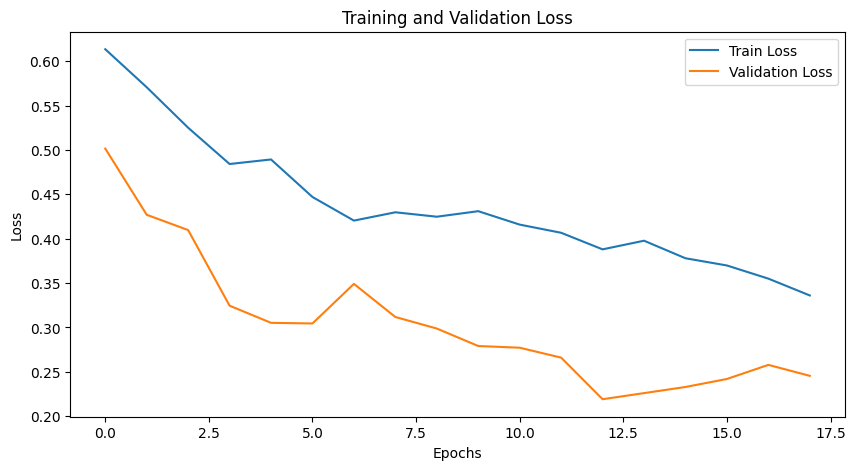

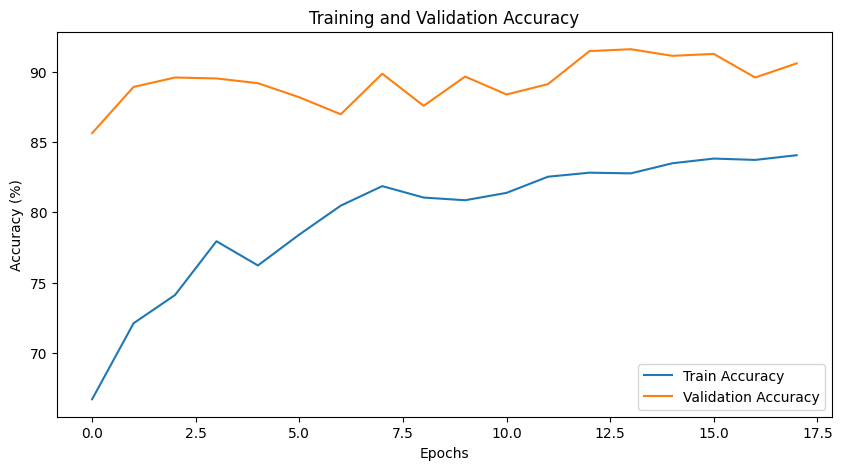

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.98      0.92      0.95      1431
     Class 1       0.24      0.64      0.35        59

    accuracy                           0.91      1490
   macro avg       0.61      0.78      0.65      1490
weighted avg       0.95      0.91      0.93      1490



CustomImageFeatureEfficientNet(
  (efficientnet): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
       

In [37]:
train_and_validate(model,effnet_train_dataloader, effnet_val_dataloader, criterion, optimizer, epochs, device, best_model_path)

## Model performance on test data

By analyzing the training and validation loss at the best epoch, as well as the test data performance metrics (with a key metric value partial AUROC of 0.124 and a recall for Class 1 at 0.64), I conclude that the newly added features and augmentations did not significantly improve the predictive results. Compared to the previous week's winning model using the original training data, which had a recall for Class 1 of 0.61 and a partial AUROC of 0.136, there was only a slight decrease in key metric.

/home/jupyter-sohka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jupyter-sohka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_1621439/2933086743.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blo

EfficientNet loaded successfully.
Model loaded successfully.
The partial AUROC of the final model on the test image is 0.1226
              precision    recall  f1-score   support

     Class 0       0.98      0.92      0.95      1431
     Class 1       0.23      0.56      0.33        59

    accuracy                           0.91      1490
   macro avg       0.61      0.74      0.64      1490
weighted avg       0.95      0.91      0.93      1490

Total misclassified images with true label 1: 26


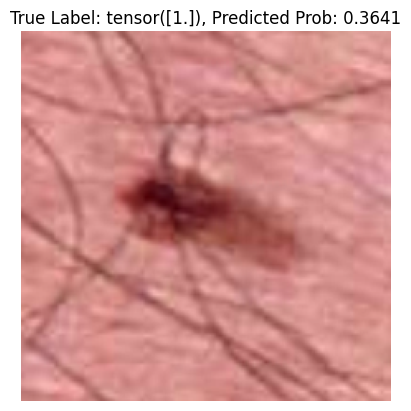

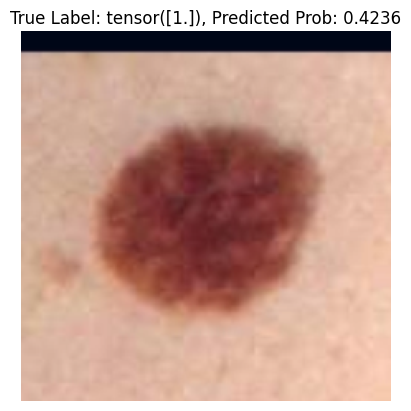

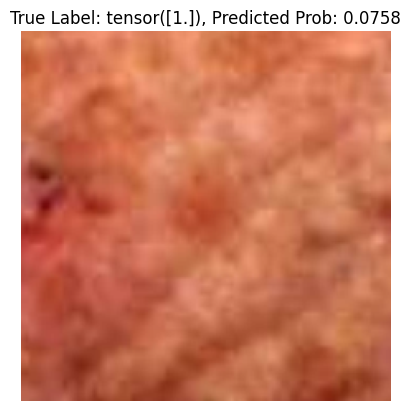

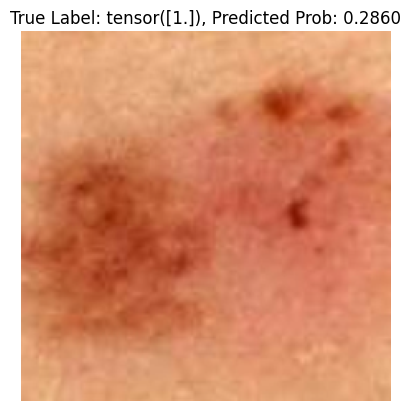

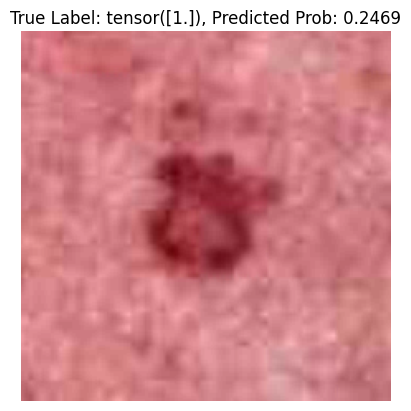

In [50]:
# Instantiate the model with the correct variable names
final_model = CustomImageFeatureEfficientNet(extracted_feature_size=525, pca_feature_size=70, metadata_size=9)
final_model_path = "best_model.path"

# Load the model's state dictionary with error handling
try:
    final_model.load_state_dict(torch.load(final_model_path, map_location=torch.device("cpu")))
    print("Model loaded successfully.")
except FileNotFoundError:
    print(f"Error: Model file not found at {final_model_path}")
    raise
except Exception as e:
    print(f"Error loading model: {e}")
    raise

# Set the model to evaluation mode
final_model.eval()

# Initialize lists to store true labels and predicted probabilities
all_labels, all_probs = [], []
misclassified_images = []

# Disable gradient calculation for evaluation to save memory and computation
with torch.no_grad():
    try:
        for i, (image, extracted_features, pca_features, metadata, labels) in enumerate(effnet_test_dataloader):
            # Move data to the specified device
            image, extracted_features, pca_features, metadata, labels = (
                image.to(device),
                extracted_features.to(device),
                pca_features.to(device),
                metadata.to(device),
                labels.float().to(device).unsqueeze(1)  # Ensure labels have the correct shape
            )

            # Get the model's predictions
            probs = final_model(image, extracted_features, pca_features, metadata)

            # Store true labels and predicted probabilities for analysis
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

            # Calculate binary predictions (0 or 1)
            predicted = (probs > 0.5).float()
            misclassified_indices = (predicted != labels).squeeze().cpu().numpy()

            # Identify misclassified images and store them
            for j, is_misclassified in enumerate(misclassified_indices):
                if is_misclassified and labels[j].cpu().item() == 1:
                    misclassified_images.append((image[j].cpu(), labels[j].cpu(), probs[j].item()))  # .item() converts the tensor to a float

        # Calculate partial AUROC for the predictions
        partial_auroc = score(np.array(all_labels), np.array(all_probs))
        print(f'The partial AUROC of the final model on the test image is {partial_auroc:.4f}')

        # Print a classification report
        print(classification_report(all_labels, (np.array(all_probs) >= 0.5).astype(int), target_names=["Class 0", "Class 1"]))

        # Display a few misclassified images if any
        # Display a few misclassified images if any
        if misclassified_images:
            print(f"Total misclassified images with true label 1: {len(misclassified_images)}")
            for i, (img, true_label, pred_prob) in enumerate(misclassified_images[:5]):
                img = img.permute(1, 2, 0).numpy()  # Convert from PyTorch tensor format to NumPy array
                
                # Ensure the image is within the range [0, 1] for floats
                if img.dtype == np.float32 or img.dtype == np.float64:
                    img = np.clip((img - img.min()) / (img.max() - img.min()), 0, 1)
                
                # Ensure the image is within the range [0, 255] for integers
                elif img.dtype == np.int32 or img.dtype == np.int64:
                    img = np.clip(img, 0, 255).astype(np.uint8)
        
                plt.imshow(img, cmap="gray" if img.shape[-1] == 1 else None)  # Display as grayscale if needed
                plt.title(f'True Label: {true_label}, Predicted Prob: {pred_prob:.4f}')
                plt.axis('off')
                plt.show()


    except Exception as e:
        print(f"Error during model evaluation: {e}")
         
    